In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [4]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [5]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...



Done.
Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)) or np.isinf(np.log(like)):


Done.


Saving fish_pretrain_post.pdf


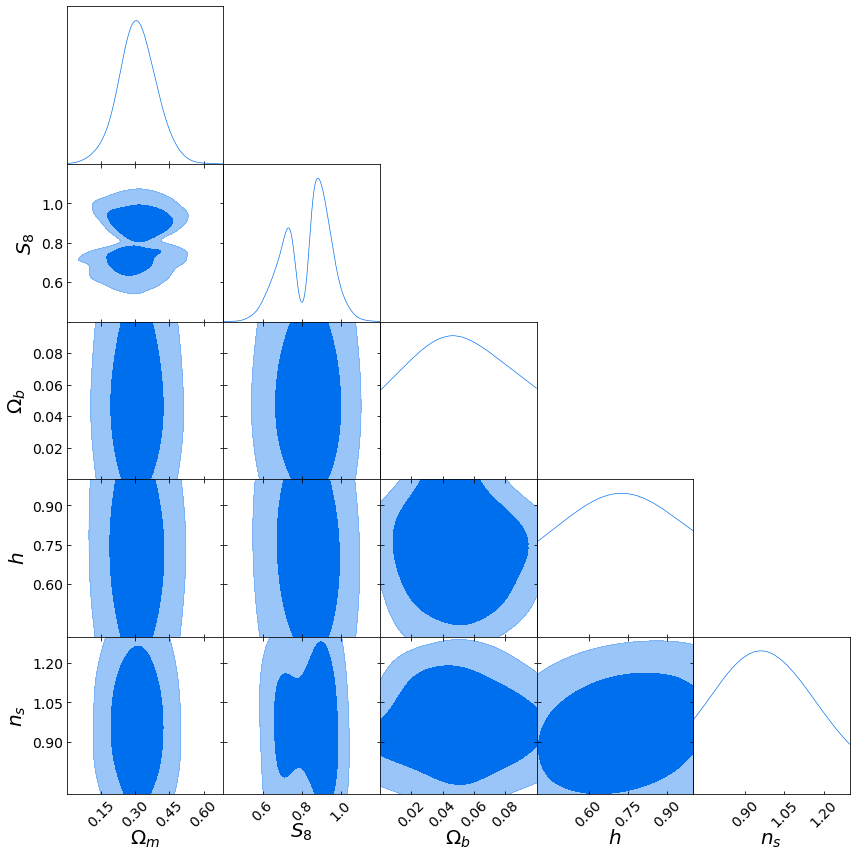

In [8]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=50, epsilon = 1e-37)

In [9]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal, epsilon = 1e-37)

Running initial 500 sims...
Simulator returns exception for parameter values: [0.30176665 0.8040983  0.05288182 0.57793557 1.00968237] (rank 0)
Simulator returns exception for parameter values: [0.3042194  0.79782702 0.07991411 0.90252199 0.91091426] (rank 0)
Simulator returns exception for parameter values: [0.30870935 0.79972198 0.03466676 0.62884509 0.96836037] (rank 0)
Simulator returns exception for parameter values: [0.29128431 0.80282839 0.05742609 0.68904926 0.97961211] (rank 0)
Simulator returns exception for parameter values: [0.28765698 0.79751877 0.01691587 0.60210874 0.95871084] (rank 0)
Simulator returns exception for parameter values: [0.31299356 0.80063016 0.05656365 0.76872541 0.93815177] (rank 0)
Simulator returns exception for parameter values: [0.29825807 0.80077278 0.07186485 0.74503342 0.9909701 ] (rank 0)
Simulator returns exception for parameter values: [0.28426392 0.79847032 0.08543042 0.84775238 0.9637552 ] (rank 0)
Simulator returns exception for parameter va

Simulator returns exception for parameter values: [0.30214383 0.80068674 0.03318828 0.66590832 0.94341924] (rank 0)
Simulator returns exception for parameter values: [0.30960041 0.79469124 0.04912994 0.68120972 0.97153385] (rank 0)
Simulator returns exception for parameter values: [0.30652731 0.8013993  0.05980275 0.7452171  0.94595753] (rank 0)
Simulator returns exception for parameter values: [0.2856511  0.7962057  0.08144754 0.96332605 0.88541879] (rank 0)
Simulator returns exception for parameter values: [0.31838105 0.80575312 0.04822534 0.73659932 0.90594427] (rank 0)
Simulator returns exception for parameter values: [0.30683464 0.80216079 0.02087151 0.48310846 1.00935248] (rank 0)
Simulator returns exception for parameter values: [0.29878005 0.79765243 0.01216664 0.59262829 0.94257175] (rank 0)
Simulator returns exception for parameter values: [0.28145725 0.80063418 0.05996955 0.94105044 0.8485173 ] (rank 0)
Simulator returns exception for parameter values: [0.29313036 0.80112774

Simulator returns exception for parameter values: [0.30409887 0.80082797 0.07127541 0.76019943 0.98070817] (rank 0)
Simulator returns exception for parameter values: [0.32507631 0.80356346 0.04740727 0.63168936 0.96372602] (rank 0)
Simulator returns exception for parameter values: [0.31807044 0.80062649 0.02547869 0.60502483 0.93673495] (rank 0)
Simulator returns exception for parameter values: [0.27804509 0.8011475  0.0255031  0.45085905 1.04357783] (rank 0)
Simulator returns exception for parameter values: [0.32129726 0.80402472 0.04829964 0.88813734 0.82603319] (rank 0)
Simulator returns exception for parameter values: [0.292958   0.80074053 0.01806456 0.76613154 0.84973633] (rank 0)
Simulator returns exception for parameter values: [0.30105825 0.79712536 0.02158926 0.63633195 0.94833899] (rank 0)
Simulator returns exception for parameter values: [0.30433517 0.80055457 0.04331319 0.63520987 0.96777043] (rank 0)
Simulator returns exception for parameter values: [0.29316886 0.80480326

 9.29129703e-01] (rank 0)
Simulator returns exception for parameter values: [0.30192878 0.80236706 0.0426865  0.71997672 0.92494656] (rank 0)
Simulator returns exception for parameter values: [0.30039233 0.80556382 0.03731779 0.71194279 0.90594798] (rank 0)
Simulator returns exception for parameter values: [0.31465642 0.7975902  0.09906766 0.90448228 0.9765049 ] (rank 0)
Simulator returns exception for parameter values: [0.29774334 0.80015365 0.05087381 0.70465692 0.96080572] (rank 0)
Simulator returns exception for parameter values: [0.29876885 0.79465487 0.03203142 0.48783254 1.0687284 ] (rank 0)
Simulator returns exception for parameter values: [0.30692183 0.79786225 0.02343192 0.55863943 0.97325479] (rank 0)
Simulator returns exception for parameter values: [0.30081335 0.79751403 0.06672511 0.95173817 0.87608676] (rank 0)
Simulator returns exception for parameter values: [0.28991157 0.79413725 0.04518828 0.69294367 0.9774361 ] (rank 0)
Simulator returns exception for parameter valu

Simulator returns exception for parameter values: [0.30576219 0.80120911 0.08652759 0.8302204  0.95056706] (rank 0)
Simulator returns exception for parameter values: [0.31205    0.79983866 0.09857652 0.93649446 0.93025286] (rank 0)
Simulator returns exception for parameter values: [0.32644086 0.80679317 0.0456768  0.5841572  0.97963801] (rank 0)
Simulator returns exception for parameter values: [0.32151265 0.80218347 0.09088564 0.87733245 0.93100589] (rank 0)
Simulator returns exception for parameter values: [0.31136014 0.80618903 0.02592891 0.42672902 1.01724208] (rank 0)
Simulator returns exception for parameter values: [0.30581105 0.79560141 0.07548445 0.72281668 0.99438195] (rank 0)
Simulator returns exception for parameter values: [0.31568307 0.80049481 0.0922216  0.76079905 1.01859112] (rank 0)
Simulator returns exception for parameter values: [0.29854776 0.79744524 0.07275912 0.94055276 0.88440598] (rank 0)
Simulator returns exception for parameter values: [0.30741298 0.80154569

Simulator returns exception for parameter values: [0.29101415 0.79323722 0.00739167 0.5954383  0.94489962] (rank 0)
Simulator returns exception for parameter values: [0.29683965 0.79918827 0.08992277 0.87525824 0.96369586] (rank 0)
Simulator returns exception for parameter values: [0.31564301 0.80847603 0.04901761 0.70328799 0.91372215] (rank 0)
Simulator returns exception for parameter values: [0.31710065 0.79590842 0.04380602 0.56329444 1.02014421] (rank 0)
Simulator returns exception for parameter values: [0.3129612  0.79954754 0.06562498 0.68156042 1.00864948] (rank 0)
Simulator returns exception for parameter values: [0.30667106 0.80374298 0.04262003 0.73917248 0.90501498] (rank 0)
Simulator returns exception for parameter values: [0.31158718 0.80271    0.06729236 0.86410403 0.89361832] (rank 0)
Simulator returns exception for parameter values: [0.30583714 0.79984472 0.07527358 0.87099704 0.91073481] (rank 0)
Simulator returns exception for parameter values: [0.28631124 0.80334313

Simulator returns exception for parameter values: [0.29108671 0.80061571 0.07384889 0.91675456 0.90357668] (rank 0)
Simulator returns exception for parameter values: [0.30736501 0.80650094 0.04083948 0.56347157 1.00513806] (rank 0)
Simulator returns exception for parameter values: [0.29499603 0.79835468 0.02603585 0.4408063  1.06726253] (rank 0)
Simulator returns exception for parameter values: [0.30070249 0.79998398 0.03960955 0.54400001 1.01251014] (rank 0)
Simulator returns exception for parameter values: [0.29819514 0.80143527 0.03169466 0.63559277 0.94998167] (rank 0)
Simulator returns exception for parameter values: [0.3082356  0.80382331 0.05385711 0.49257366 1.06392415] (rank 0)
Simulator returns exception for parameter values: [0.3019714  0.79889831 0.07793551 0.88730078 0.9364174 ] (rank 0)
Simulator returns exception for parameter values: [0.3056237  0.79842766 0.06344672 0.69879826 1.00493656] (rank 0)
Simulator returns exception for parameter values: [0.31199278 0.80696672

Simulator returns exception for parameter values: [0.31040616 0.79874165 0.06088218 0.76104774 0.94969218] (rank 0)
Simulator returns exception for parameter values: [0.29985806 0.79663734 0.04097729 0.82093921 0.88030479] (rank 0)
Simulator returns exception for parameter values: [0.30132575 0.79833803 0.05806919 0.80354542 0.9318023 ] (rank 0)
Simulator returns exception for parameter values: [0.30994981 0.80455108 0.04295965 0.59550297 0.98151087] (rank 0)
Simulator returns exception for parameter values: [0.31639983 0.8027746  0.0477937  0.61326995 0.98552807] (rank 0)
Simulator returns exception for parameter values: [0.30523041 0.80873732 0.0350898  0.59463764 0.95341082] (rank 0)
Simulator returns exception for parameter values: [0.29146049 0.79922847 0.0297495  0.74934531 0.89234055] (rank 0)
Simulator returns exception for parameter values: [0.28754498 0.79518753 0.02309814 0.58911071 0.98714623] (rank 0)
Simulator returns exception for parameter values: [0.3045308  0.80370766

Simulator returns exception for parameter values: [0.29558813 0.80592768 0.04768484 0.51639398 1.03911113] (rank 0)
Simulator returns exception for parameter values: [0.30426654 0.80487798 0.01453082 0.50035313 0.9664492 ] (rank 0)
Simulator returns exception for parameter values: [0.30599267 0.80274416 0.04888644 0.57434537 1.01729511] (rank 0)
Simulator returns exception for parameter values: [0.32079928 0.79779199 0.07209429 0.734808   0.98581869] (rank 0)
Simulator returns exception for parameter values: [0.29412138 0.79906976 0.08862194 0.99421712 0.8939412 ] (rank 0)
Simulator returns exception for parameter values: [0.31046083 0.80472683 0.04914152 0.76691805 0.90817587] (rank 0)
Simulator returns exception for parameter values: [0.30817794 0.80047514 0.00274306 0.40197498 1.00189199] (rank 0)
Simulator returns exception for parameter values: [0.30453354 0.79945981 0.01172035 0.67489522 0.87854795] (rank 0)
Simulator returns exception for parameter values: [0.30627985 0.80080343

Simulator returns exception for parameter values: [0.31247991 0.80609691 0.0804116  0.80581695 0.93616299] (rank 0)
Simulator returns exception for parameter values: [0.30907579 0.80184576 0.06822882 0.81522081 0.93050328] (rank 0)
Simulator returns exception for parameter values: [0.30063763 0.79763423 0.0124499  0.54073286 0.96409207] (rank 0)
Simulator returns exception for parameter values: [0.29625818 0.79898994 0.02083803 0.50244112 1.00689653] (rank 0)
Simulator returns exception for parameter values: [0.29370589 0.79923543 0.0441945  0.58553591 1.03014556] (rank 0)
Simulator returns exception for parameter values: [0.31304545 0.8008903  0.09643071 0.81778092 0.99076056] (rank 0)
Simulator returns exception for parameter values: [0.29088911 0.79851522 0.08630145 0.95222696 0.91181469] (rank 0)
Simulator returns exception for parameter values: [0.29047044 0.79447719 0.06834198 0.82980184 0.9397534 ] (rank 0)
Simulator returns exception for parameter values: [0.30793867 0.79892947

IndexError: index 2500 is out of bounds for axis 0 with size 2500

In [ ]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()